# IEEE Access Paper: A Deep Learning Approach Based on Explainable Artificial Intelligence for Skin Lesion Classification
**By: University of Engineering and Technology,Lahore,pakistan**

# Import Libraries

In [2]:
# Import libraries (unchanged)
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score
from torch.amp import GradScaler, autocast
import cv2
from skimage.feature import graycomatrix, graycoprops
import seaborn as sns
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import os
import multiprocessing as mp
from functools import partial

# GPU Information

In [3]:
!nvidia-smi

Wed Apr 30 06:20:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Step 1: Fix GPU detection (unchanged)
print("=== Starting GPU Setup ===")
print("Uninstalling existing PyTorch packages...")
!pip uninstall -y torch torchvision torchaudio
print("Installing PyTorch with CUDA 11.8 support...")
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Verify GPU availability (unchanged)
print("\n=== Verifying GPU Availability ===")
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU not detected. Running on CPU. Please check PyTorch installation or Kaggle accelerator settings.")
    print("Falling back to CPU for now. We may switch to TensorFlow if this persists.")

# Define device early (unchanged)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

=== Starting GPU Setup ===
Uninstalling existing PyTorch packages...
Found existing installation: torch 2.7.0+cu118
Uninstalling torch-2.7.0+cu118:
  Successfully uninstalled torch-2.7.0+cu118
Found existing installation: torchvision 0.22.0+cu118
Uninstalling torchvision-0.22.0+cu118:
  Successfully uninstalled torchvision-0.22.0+cu118
Found existing installation: torchaudio 2.7.0+cu118
Uninstalling torchaudio-2.7.0+cu118:
  Successfully uninstalled torchaudio-2.7.0+cu118
Installing PyTorch with CUDA 11.8 support...
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.0%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.22.0%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.7.0%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.6 kB)
Using cached https

# Data Collection

In [5]:
# 2. Data Collection: Load DermaMNIST dataset (unchanged)
print("\n=== Loading DermaMNIST Dataset ===")
dataset_path = "/kaggle/input/dermamnist/dermamnist_224.npz"
data = np.load(dataset_path)
train_images = data['train_images']
train_labels = data['train_labels'].flatten()
val_images = data['val_images']
val_labels = data['val_labels'].flatten()
test_images = data['test_images']
test_labels = data['test_labels'].flatten()

# Class names for DermaMNIST (unchanged)
class_names = [
    'basal cell carcinoma', 'squamous cell carcinoma', 'melanoma',
    'actinic keratosis', 'benign keratosis', 'dermatofibroma', 'vascular lesion'
]
print("Number of training images:", len(train_images))
print("Number of validation images:", len(val_images))
print("Number of test images:", len(test_images))
print("Class distribution (train):", np.bincount(train_labels))


=== Loading DermaMNIST Dataset ===
Number of training images: 7007
Number of validation images: 1003
Number of test images: 2005
Class distribution (train): [ 228  359  769   80  779 4693   99]


# Step-1: Image Preprocessing & Segmentation  
To enhance image quality and focus on the lesion areas, the following preprocessing steps are applied:​

1.  **Objective:** Enhance image quality, standardize dimensions, and focus on regions of interest (ROIs).

    I’ll preprocess images by:
    
    * Applying noise reduction (Gaussian blur).
    * Resizing to 224x224 (standard for models like ResNet).
    * Normalizing pixel values to [0, 1].
    * Cropping ROIs (simplified to central cropping for now).
1. **Implementation:**

Since the dataset is large, we’ll preprocess images on-the-fly during training to save memory, using a generator.
We’ll assume metadata.csv has columns like isic_id (image filename without extension) and diagnosis (label).

In [6]:
# 3. Preprocessing: Precompute Segmentation and Haralick Features with Multiprocessing
print("\n=== Preprocessing: Segmentation and Haralick Feature Extraction ===")

def segment_image(image):
    img = np.array(image)
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    height, width = img.shape[:2]
    rect = (10, 10, width-20, height-20)
    # Reduce iterations for faster processing (from 5 to 3)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 3, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask2 = cv2.dilate(mask2, kernel, iterations=1)
    segmented = img * mask2[:, :, np.newaxis]
    return segmented

def compute_haralick_features(image):
    # Convert image to grayscale
    img = np.array(Image.fromarray(image).convert('L'))
    # Compute GLCM
    glcm = graycomatrix(img, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    
    # Compute standard Haralick features using graycoprops
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    
    # Compute additional Haralick features manually
    glcm = glcm[:, :, 0, 0]  # Extract the 2D GLCM matrix
    glcm = glcm / (glcm.sum() + 1e-8)  # Ensure normalization (avoid division by zero)
    
    # Entropy
    entropy = -np.sum(glcm * np.log2(glcm + 1e-8))  # Add small epsilon to avoid log(0)
    
    # Variance
    i, j = np.indices(glcm.shape)
    mu = np.sum(i * glcm)
    variance = np.sum((i - mu) ** 2 * glcm)
    
    # Sum Average and Sum Entropy
    p_x_plus_y = np.zeros(2 * 255 - 1)
    for i in range(255):
        for j in range(255):
            p_x_plus_y[i + j] += glcm[i, j]
    sum_average = np.sum(np.arange(2 * 255 - 1) * p_x_plus_y)
    sum_entropy = -np.sum(p_x_plus_y * np.log2(p_x_plus_y + 1e-8))
    
    # Difference Variance and Difference Entropy
    p_x_minus_y = np.zeros(255)
    for i in range(255):
        for j in range(255):
            p_x_minus_y[abs(i - j)] += glcm[i, j]
    difference_variance = np.sum((np.arange(255) - np.sum(np.arange(255) * p_x_minus_y)) ** 2 * p_x_minus_y)
    difference_entropy = -np.sum(p_x_minus_y * np.log2(p_x_minus_y + 1e-8))
    
    # Combine all features into a single array
    features = np.array([
        contrast, correlation, energy, homogeneity,
        entropy, variance, sum_average, sum_entropy,
        difference_variance, difference_entropy
    ])
    return features

def process_image(img, idx, total):
    if idx % 500 == 0:
        print(f"Processed {idx}/{total} images...")
    segmented = segment_image(img)
    haralick = compute_haralick_features(segmented)
    return segmented, haralick

# Precompute and save segmented images and Haralick features using multiprocessing
output_dir = "/kaggle/working/preprocessed_dermamnist"
os.makedirs(output_dir, exist_ok=True)

def preprocess_and_save(images, split_name):
    segmented_path = os.path.join(output_dir, f"{split_name}_segmented.npy")
    haralick_path = os.path.join(output_dir, f"{split_name}_haralick.npy")
    
    if os.path.exists(segmented_path) and os.path.exists(haralick_path):
        print(f"Loading precomputed {split_name} data...")
        segmented_images = np.load(segmented_path)
        haralick_features = np.load(haralick_path)
    else:
        print(f"Preprocessing {split_name} data ({len(images)} images) with multiprocessing...")
        num_cores = mp.cpu_count()
        print(f"Using {num_cores} CPU cores for preprocessing.")
        pool = mp.Pool(processes=num_cores)
        process_func = partial(process_image, total=len(images))
        results = pool.starmap(process_func, [(img, i) for i, img in enumerate(images)])
        pool.close()
        pool.join()
        segmented_images = np.array([r[0] for r in results])
        haralick_features = np.array([r[1] for r in results])
        # Save to disk
        np.save(segmented_path, segmented_images)
        np.save(haralick_path, haralick_features)
        print(f"Saved precomputed {split_name} data.")
    
    return segmented_images, haralick_features

# Preprocess all splits
print("Preprocessing training set...")
train_segmented, train_haralick = preprocess_and_save(train_images, "train")
print("Preprocessing validation set...")
val_segmented, val_haralick = preprocess_and_save(val_images, "val")
print("Preprocessing test set...")
test_segmented, test_haralick = preprocess_and_save(test_images, "test")

# Custom Dataset for DermaMNIST (unchanged except variable names)
class DermaMNISTDataset(Dataset):
    def __init__(self, images, haralick_features, labels, transform=None):
        self.images = images
        self.haralick_features = haralick_features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        haralick_features = self.haralick_features[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, haralick_features, label


=== Preprocessing: Segmentation and Haralick Feature Extraction ===
Preprocessing training set...
Loading precomputed train data...
Preprocessing validation set...
Loading precomputed val data...
Preprocessing test set...
Loading precomputed test data...


# Step-2: Data Augmentation
To increase data diversity and prevent overfitting, the following augmentation techniques are applied:​

* **Rotation:** Random rotations at various angles.​

* **Flipping:** Horizontal and vertical flips.​

* **Cropping:** Random crops to simulate zoom.​

* **Brightness and Contrast Adjustment:** Randomly altering brightness and contrast levels.​

* **Noise Addition:** Introducing random noise to images.

In [7]:
# Transforms (unchanged)
train_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=30, shear=10, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1))
])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Step-3: Model Training with ResNet-18
Utilizing transfer learning, a pre-trained ResNet-18 model is fine-tuned for skin lesion classification. The final fully connected layer is modified to output predictions for the nine classes present in the ISIC 2019 dataset.

In [8]:
# Creating Datasets and DataLoaders (unchanged except variable names)
print("\n=== Creating Datasets and DataLoaders ===")
train_dataset = DermaMNISTDataset(train_segmented, train_haralick, train_labels, transform=train_transforms)
val_dataset = DermaMNISTDataset(val_segmented, val_haralick, val_labels, transform=val_transforms)
test_dataset = DermaMNISTDataset(test_segmented, test_haralick, test_labels, transform=val_transforms)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
print(f"Created DataLoaders with batch size {batch_size}")


=== Creating Datasets and DataLoaders ===
Created DataLoaders with batch size 32


In [9]:
# 4. Classification: ResNet18 + MLP for Feature Fusion
print("\n=== Setting Up Model ===")

class CombinedModel(nn.Module):
    def __init__(self, num_classes, haralick_feature_dim=10):  # Updated to 10 for Haralick features
        super(CombinedModel, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        resnet_fc_dim = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.haralick_fc = nn.Linear(haralick_feature_dim, 64)  # Updated name
        self.combined_fc = nn.Sequential(
            nn.Linear(resnet_fc_dim + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, haralick_features):
        resnet_features = self.resnet(x)
        haralick_features = self.haralick_fc(haralick_features)
        combined = torch.cat((resnet_features, haralick_features), dim=1)
        output = self.combined_fc(combined)
        return output

# Normalize Haralick features
print("Normalizing Haralick features...")
haralick_scaler = StandardScaler()  # Renamed to avoid conflict
haralick_scaler.fit(train_haralick)

# Compute class weights (unchanged)
print("Computing class weights...")
class_counts = np.bincount(train_labels)
class_weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float)
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = class_weights.to(device)

model = CombinedModel(num_classes=len(class_names)).to(device)
print(f"Model initialized on device: {next(model.parameters()).device}")

# Loss, optimizer, and scaler (unchanged)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

# Training loop (unchanged except variable names)
print("\n=== Starting Training ===")
num_epochs = 15
best_val_acc = 0.0
for epoch in range(num_epochs):
    print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        if i % 50 == 0:
            print(f"  Batch {i}/{len(train_loader)}")
        inputs, haralick_features, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        haralick_features = haralick_scaler.transform(haralick_features.numpy())
        haralick_features = torch.tensor(haralick_features, dtype=torch.float32).to(device)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(inputs, haralick_features)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    print(f"Validating Epoch {epoch+1}...")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, haralick_features, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            haralick_features = haralick_scaler.transform(haralick_features.numpy())
            haralick_features = torch.tensor(haralick_features, dtype=torch.float32).to(device)
            with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs, haralick_features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    print(f"Validation Acc: {val_acc:.2f}%")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model with validation accuracy:", best_val_acc)
    if val_acc > 95:
        print("Validation accuracy > 95%, stopping training.")
        break

# Clear memory after training (unchanged)
torch.cuda.empty_cache()
print("Training complete, GPU memory cleared.")


=== Setting Up Model ===
Normalizing Haralick features...
Computing class weights...
Model initialized on device: cuda:0

=== Starting Training ===

Starting Epoch 1/15


/tmp/ipykernel_278/1682120262.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


  Batch 0/219
  Batch 50/219
  Batch 100/219
  Batch 150/219
  Batch 200/219
Epoch 1, Loss: 1.4045, Train Acc: 52.70%
Validating Epoch 1...
Validation Acc: 59.42%
Saved best model with validation accuracy: 59.42173479561316

Starting Epoch 2/15
  Batch 0/219
  Batch 50/219
  Batch 100/219
  Batch 150/219
  Batch 200/219
Epoch 2, Loss: 1.0458, Train Acc: 60.87%
Validating Epoch 2...
Validation Acc: 63.21%
Saved best model with validation accuracy: 63.21036889332004

Starting Epoch 3/15
  Batch 0/219
  Batch 50/219
  Batch 100/219
  Batch 150/219
  Batch 200/219
Epoch 3, Loss: 0.9239, Train Acc: 63.22%
Validating Epoch 3...
Validation Acc: 60.32%

Starting Epoch 4/15
  Batch 0/219
  Batch 50/219
  Batch 100/219
  Batch 150/219
  Batch 200/219
Epoch 4, Loss: 0.9122, Train Acc: 63.35%
Validating Epoch 4...
Validation Acc: 67.50%
Saved best model with validation accuracy: 67.4975074775673

Starting Epoch 5/15
  Batch 0/219
  Batch 50/219
  Batch 100/219
  Batch 150/219
  Batch 200/219
Epoch

# Model Explainability with the LIME + GradCam
To interpret the model's predictions, LIME (Local Interpretable Model-Agnostic Explanations) is employed. LIME provides visual explanations by highlighting regions in the image that most influenced the model's decision.


=== Running Explainability Analysis ===
Preparing sample for LIME and Grad-CAM...
Running LIME explanation...


  0%|          | 0/500 [00:00<?, ?it/s]

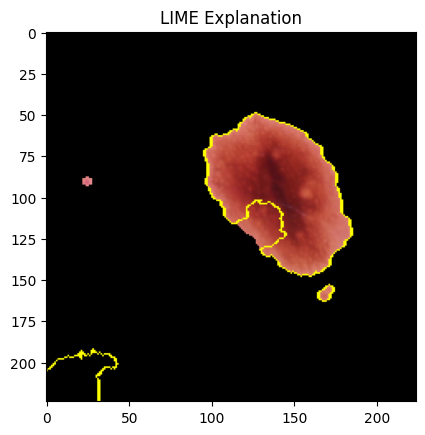

Running Grad-CAM explanation...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


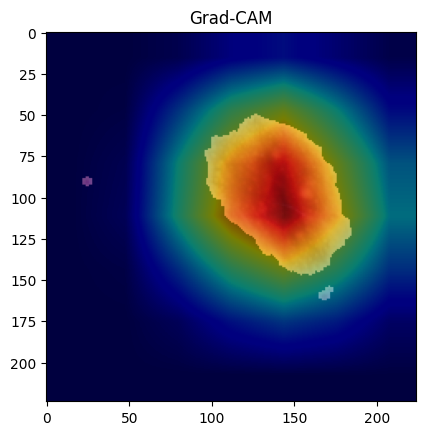

Explainability analysis complete, GPU memory cleared.


In [10]:
print("\n=== Running Explainability Analysis ===")

# Grad-CAM implementation (unchanged)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def __call__(self, x, haralick_features, index=None):
        self.model.eval()
        output = self.model(x, haralick_features)
        if index is None:
            index = torch.argmax(output, dim=1)
        self.model.zero_grad()
        score = output[0, index]
        score.backward()
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam.cpu().detach().numpy()

# Explainability (unchanged except variable names)
print("Preparing sample for LIME and Grad-CAM...")
model.eval()
sample_idx = 0
sample_image = Image.fromarray(val_segmented[sample_idx])
sample_haralick = val_haralick[sample_idx]
sample_haralick = haralick_scaler.transform([sample_haralick])[0]
sample_haralick = torch.tensor(sample_haralick, dtype=torch.float32).unsqueeze(0).to(device)

# Preprocess for LIME and Grad-CAM
lime_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
sample_tensor = lime_transform(sample_image).unsqueeze(0).to(device)

# LIME
print("Running LIME explanation...")
def predict_fn(images):
    images = torch.from_numpy(images.transpose((0, 3, 1, 2))).float().to(device)
    images = images / 255.0
    images = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(images)
    haralick_batch = sample_haralick.repeat(images.shape[0], 1)
    with torch.no_grad():
        with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(images, haralick_batch)
    return outputs.cpu().numpy()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    np.array(sample_image),
    predict_fn,
    top_labels=5,
    num_samples=500
)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5)
plt.imshow(mark_boundaries(np.array(sample_image)/255.0, mask))
plt.title("LIME Explanation")
plt.show()

# Grad-CAM
print("Running Grad-CAM explanation...")
gradcam = GradCAM(model, model.resnet.layer4[-1])
cam = gradcam(sample_tensor, sample_haralick)
cam = cv2.resize(cam[0], (224, 224))
plt.imshow(np.array(sample_image))
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM")
plt.show()

torch.cuda.empty_cache()
print("Explainability analysis complete, GPU memory cleared.")

# Evaluation Matrix


=== Evaluating Model on Test Set ===
Evaluating batch 0/63...
Evaluating batch 20/63...
Evaluating batch 40/63...
Evaluating batch 60/63...
Shape of all_probs: (2005, 7)
Min sum of probabilities before normalization: 0.999603271484375
Max sum of probabilities before normalization: 1.0003580451011658
Performing probability normalization...
Correcting any remaining deviations...
Min sum after final normalization: 0.9999999999999998
Max sum after final normalization: 1.0000000000000002
All probabilities sum to 1.0 within scikit-learn's tolerance.

=== Evaluation Metrics ===
Test Accuracy: 72.42%
Test Precision (weighted): 0.8024
Test Recall (weighted): 0.7242
Test F1 Score (weighted): 0.7462
Test ROC-AUC (ovr): 0.9470

Plotting Confusion Matrix...


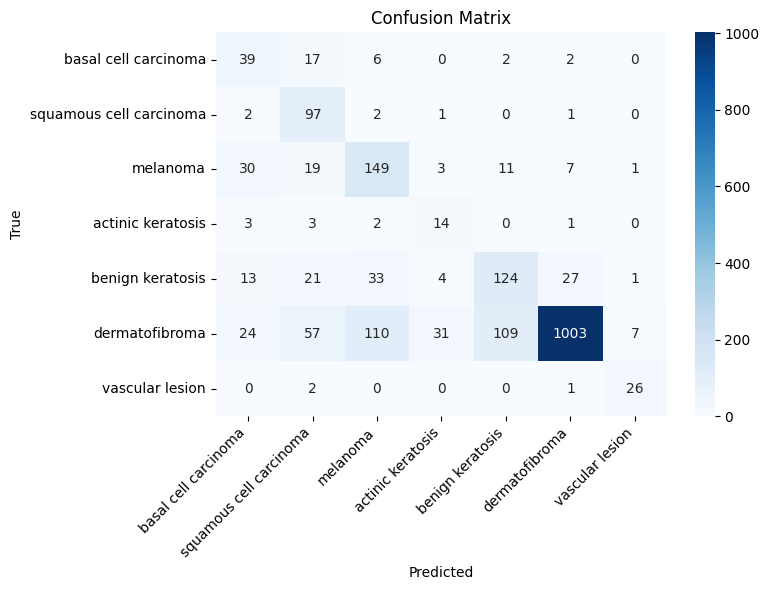


Per-Class Metrics:
basal cell carcinoma:
  Precision: 0.3514
  Recall: 0.5909
  F1 Score: 0.4407
squamous cell carcinoma:
  Precision: 0.4491
  Recall: 0.9417
  F1 Score: 0.6082
melanoma:
  Precision: 0.4934
  Recall: 0.6773
  F1 Score: 0.5709
actinic keratosis:
  Precision: 0.2642
  Recall: 0.6087
  F1 Score: 0.3684
benign keratosis:
  Precision: 0.5041
  Recall: 0.5561
  F1 Score: 0.5288
dermatofibroma:
  Precision: 0.9626
  Recall: 0.7479
  F1 Score: 0.8418
vascular lesion:
  Precision: 0.7429
  Recall: 0.8966
  F1 Score: 0.8125
Evaluation complete, GPU memory cleared.


In [11]:
print("\n=== Evaluating Model on Test Set ===")
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import normalize

# Evaluate on test set (unchanged except variable names)
model.eval()
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        if i % 20 == 0:
            print(f"Evaluating batch {i}/{len(test_loader)}...")
        inputs, haralick_features, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        haralick_features = haralick_scaler.transform(haralick_features.numpy())
        haralick_features = torch.tensor(haralick_features, dtype=torch.float32).to(device)
        with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(inputs, haralick_features)
        
        # Apply softmax to get probabilities
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert all_probs to a NumPy array and verify shape
all_probs = np.array(all_probs, dtype=np.float64)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Debug: Check for numerical issues
print(f"Shape of all_probs: {all_probs.shape}")
print(f"Min sum of probabilities before normalization: {all_probs.sum(axis=1).min()}")
print(f"Max sum of probabilities before normalization: {all_probs.sum(axis=1).max()}")

# Handle edge cases
if np.any(np.isnan(all_probs)):
    print("Found NaN values in probabilities, replacing with uniform probabilities...")
    num_classes = all_probs.shape[1]
    all_probs[np.isnan(all_probs)] = 1.0 / num_classes

zero_sum_rows = all_probs.sum(axis=1) == 0
if np.any(zero_sum_rows):
    print(f"Found {np.sum(zero_sum_rows)} rows summing to zero, replacing with uniform probabilities...")
    num_classes = all_probs.shape[1]
    all_probs[zero_sum_rows] = 1.0 / num_classes

if np.any(all_probs < 0):
    print("Found negative probabilities, clipping to zero...")
    all_probs = np.maximum(all_probs, 0)

# Normalize probabilities
print("Performing probability normalization...")
all_probs = normalize(all_probs, norm='l1', axis=1)
sums = all_probs.sum(axis=1, keepdims=True)
all_probs = all_probs / sums
print("Correcting any remaining deviations...")
epsilon = 1e-16
sums = all_probs.sum(axis=1)
deviations = 1.0 - sums
all_probs += deviations[:, np.newaxis] / all_probs.shape[1]
all_probs = np.maximum(all_probs, 0)
all_probs = normalize(all_probs, norm='l1', axis=1)

# Verify normalization
print(f"Min sum after final normalization: {all_probs.sum(axis=1).min()}")
print(f"Max sum after final normalization: {all_probs.sum(axis=1).max()}")
if not np.allclose(all_probs.sum(axis=1), 1.0, rtol=1e-5, atol=1e-8):
    print("Error: Probabilities do not meet scikit-learn's tolerance for roc_auc_score!")
    sums = all_probs.sum(axis=1)
    deviations = np.abs(sums - 1.0)
    problematic_indices = np.where(deviations > 1e-8)[0]
    print(f"Max deviation from 1.0: {deviations.max()}")
    print(f"Indices of problematic rows: {problematic_indices}")
    for idx in problematic_indices[:3]:
        print(f"Row {idx} sum: {sums[idx]}, probabilities: {all_probs[idx]}")
    raise ValueError("Probabilities do not sum to 1.0 within scikit-learn's tolerance.")
else:
    print("All probabilities sum to 1.0 within scikit-learn's tolerance.")

# Compute metrics
print("\n=== Evaluation Metrics ===")
accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).mean()
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Test Precision (weighted): {precision:.4f}")
print(f"Test Recall (weighted): {recall:.4f}")
print(f"Test F1 Score (weighted): {f1:.4f}")
print(f"Test ROC-AUC (ovr): {roc_auc:.4f}")

# Confusion Matrix
print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class metrics
print("\nPer-Class Metrics:")
per_class_precision = precision_score(all_labels, all_preds, average=None)
per_class_recall = recall_score(all_labels, all_preds, average=None)
per_class_f1 = f1_score(all_labels, all_preds, average=None)
for i, class_name in enumerate(class_names):
    print(f"{class_name}:")
    print(f"  Precision: {per_class_precision[i]:.4f}")
    print(f"  Recall: {per_class_recall[i]:.4f}")
    print(f"  F1 Score: {per_class_f1[i]:.4f}")

torch.cuda.empty_cache()
print("Evaluation complete, GPU memory cleared.")

# Visualizations


=== Additional Visualizations ===
Plotting Confusion Matrix...


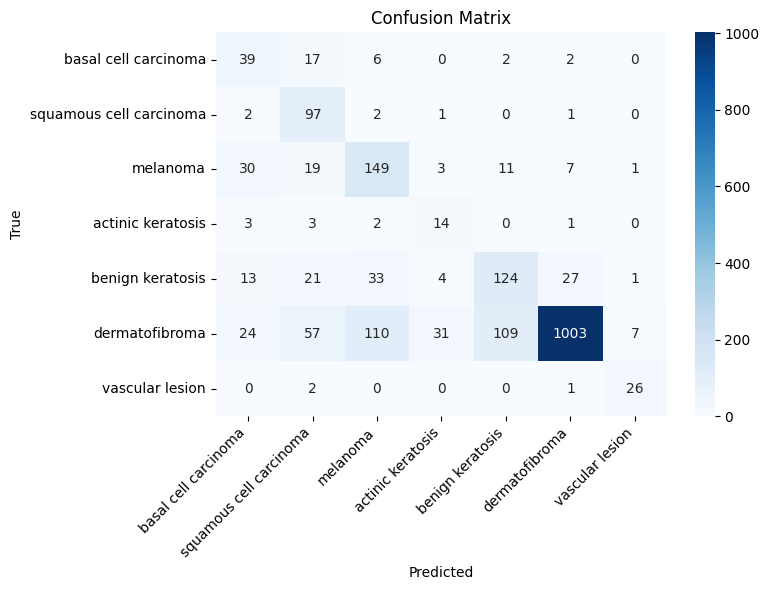

Confusion matrix plot displayed.

Plotting Normalized Confusion Matrix...


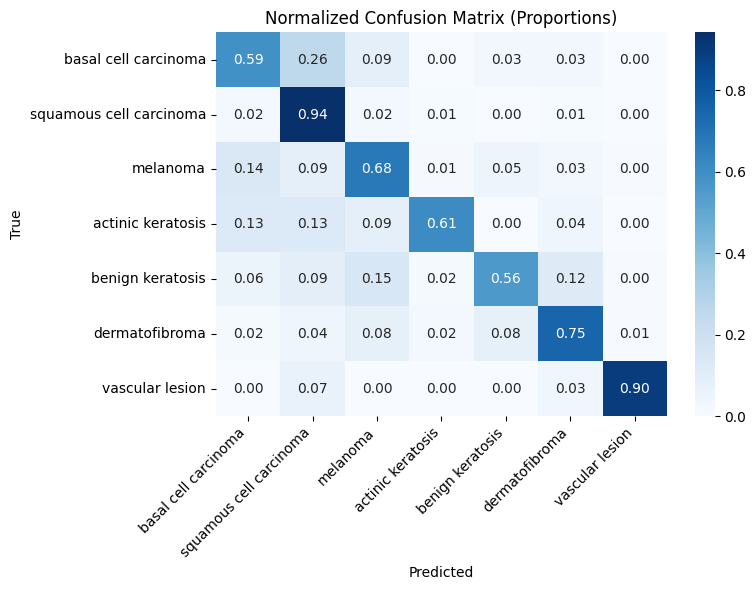

Normalized confusion matrix plot displayed.

Plotting ROC Curves (One-vs-Rest)...


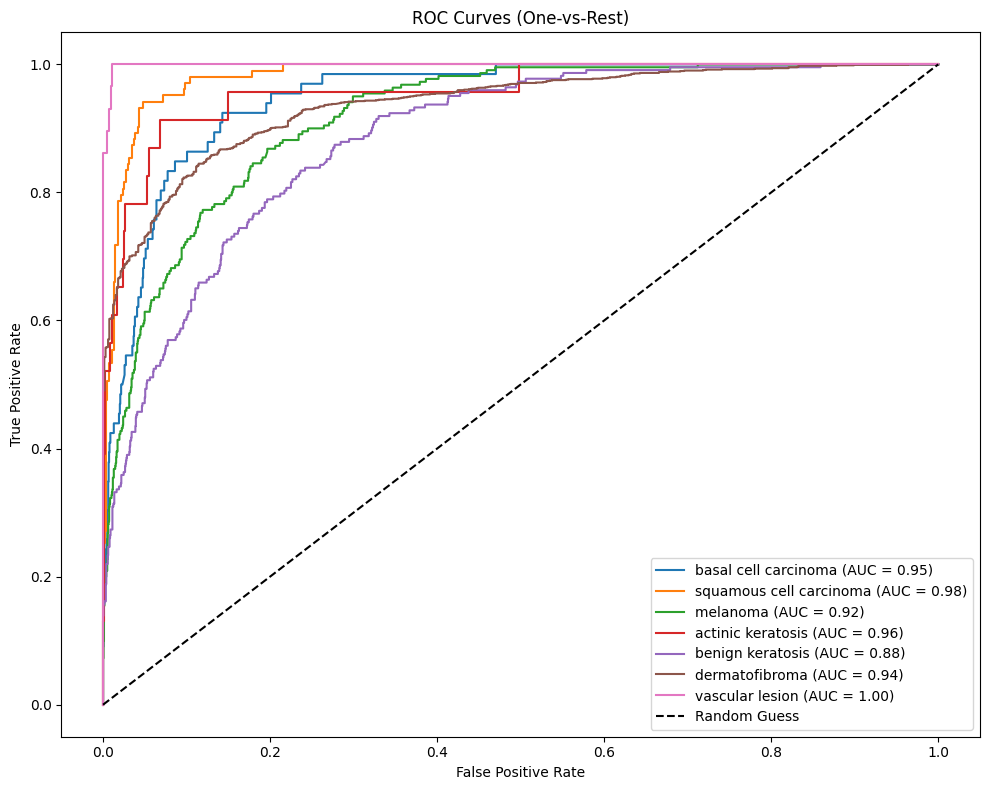

ROC curves plot displayed.

Plotting Precision-Recall Curves (One-vs-Rest)...


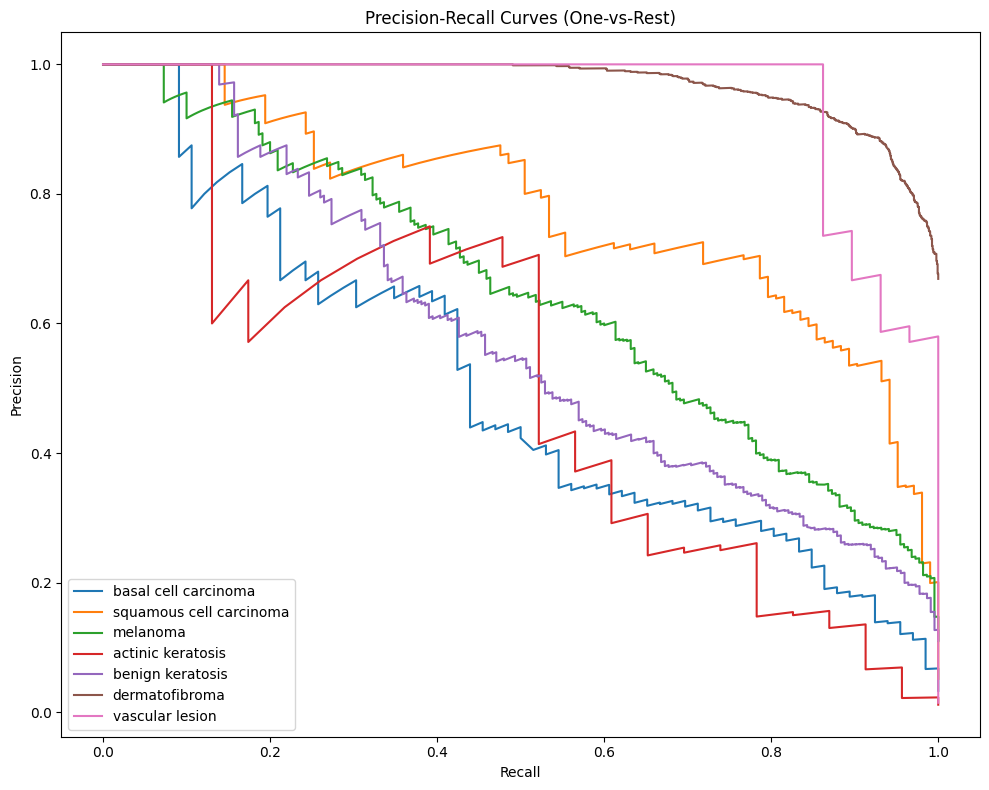

Precision-recall curves plot displayed.

Plotting Class-wise Prediction Distribution...


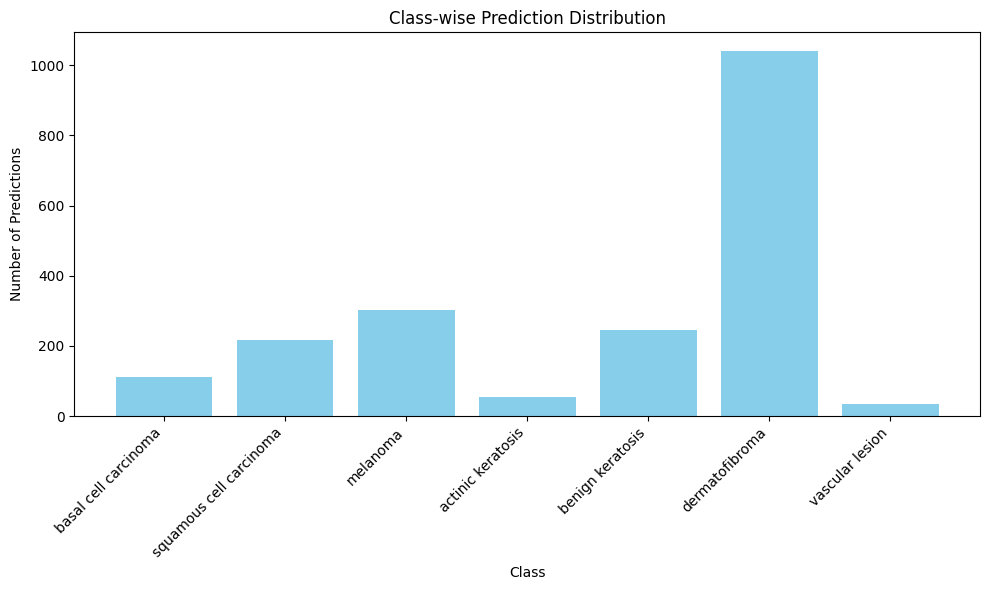

Prediction distribution plot displayed.

Plotting Per-Class Metric Bar Plots...


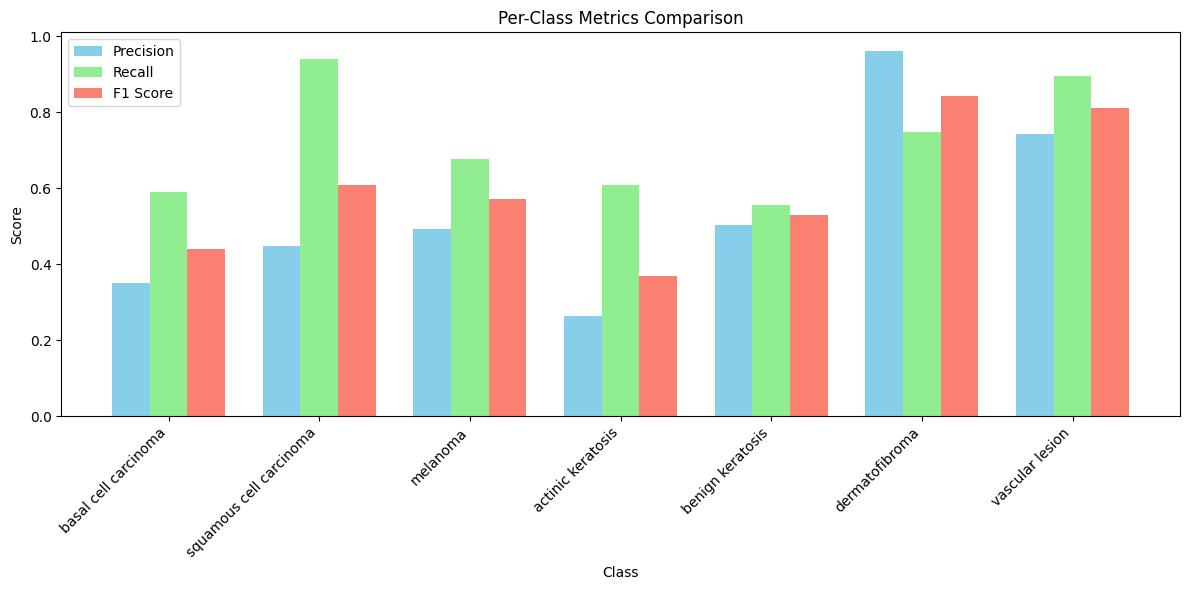

Per-class metrics bar plot displayed.

All additional visualizations complete.


In [12]:
# Additional Visualizations (unchanged)
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

if 'all_preds' not in globals() or 'all_labels' not in globals() or 'all_probs' not in globals() or 'class_names' not in globals():
    raise ValueError("Required variables (all_preds, all_labels, all_probs, class_names) are not defined. Run the evaluation section first.")

print("\n=== Additional Visualizations ===")

print("Plotting Confusion Matrix...")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print("Confusion matrix plot displayed.")

print("\nPlotting Normalized Confusion Matrix...")
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix (Proportions)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print("Normalized confusion matrix plot displayed.")

print("\nPlotting ROC Curves (One-vs-Rest)...")
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    true_binary = (all_labels == i).astype(int)
    probas = all_probs[:, i]
    fpr, tpr, _ = roc_curve(true_binary, probas)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
print("ROC curves plot displayed.")

print("\nPlotting Precision-Recall Curves (One-vs-Rest)...")
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    true_binary = (all_labels == i).astype(int)
    probas = all_probs[:, i]
    precision, recall, _ = precision_recall_curve(true_binary, probas)
    plt.plot(recall, precision, label=f'{class_names[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (One-vs-Rest)')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()
print("Precision-recall curves plot displayed.")

print("\nPlotting Class-wise Prediction Distribution...")
pred_counts = np.bincount(all_preds, minlength=len(class_names))
plt.figure(figsize=(10, 6))
plt.bar(class_names, pred_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Predictions')
plt.title('Class-wise Prediction Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("Prediction distribution plot displayed.")

print("\nPlotting Per-Class Metric Bar Plots...")
per_class_precision = precision_score(all_labels, all_preds, average=None)
per_class_recall = recall_score(all_labels, all_preds, average=None)
per_class_f1 = f1_score(all_labels, all_preds, average=None)

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, per_class_precision, width, label='Precision', color='skyblue')
ax.bar(x, per_class_recall, width, label='Recall', color='lightgreen')
ax.bar(x + width, per_class_f1, width, label='F1 Score', color='salmon')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Per-Class Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()
print("Per-class metrics bar plot displayed.")

print("\nAll additional visualizations complete.")